# Benchmarking feature selection algorithms in the molecular property prediction space

In [1]:
import warnings

warnings.simplefilter('ignore')

## Lipophilicity

Lipophilicity measures the ability of a drug to dissolve in a lipid (e.g. fats, oils) environment. High lipophilicity often leads to high rate of metabolism, poor solubility, high turn-over, and low absorption

In [2]:
#LIPOPHILICITY (REGRESSION)

from tdc.single_pred import ADME
data = ADME(name = 'Lipophilicity_AstraZeneca')
#DF contains the whole dataset stored in a Pandas dataframe format 
df = data.get_data()
#Get_split divides the dataset into 3 different sets (Train, validation, test)
split_LIPO = data.get_split()

Found local copy...
Loading...
Done!


In [85]:
split_LIPO['train'].head()

,Drug_ID,Drug,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69
3,CHEMBL317462,OC1(C#Cc2ccc(-c3ccccc3)cc2)CN2CCC1CC2,3.14
4,CHEMBL1940306,CS(=O)(=O)c1ccc(Oc2ccc(C#C[C@]3(O)CN4CCC3CC4)c...,1.51


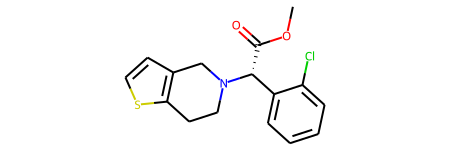

In [3]:
#This would be the way of displaying the drug's chemical representation
from rdkit import Chem

mol = Chem.MolFromSmiles(split_LIPO['train']['Drug'][2])
mol

In [9]:
print(dir(Descriptors))

['AUTOCORR2D_1', 'AUTOCORR2D_10', 'AUTOCORR2D_100', 'AUTOCORR2D_101', 'AUTOCORR2D_102', 'AUTOCORR2D_103', 'AUTOCORR2D_104', 'AUTOCORR2D_105', 'AUTOCORR2D_106', 'AUTOCORR2D_107', 'AUTOCORR2D_108', 'AUTOCORR2D_109', 'AUTOCORR2D_11', 'AUTOCORR2D_110', 'AUTOCORR2D_111', 'AUTOCORR2D_112', 'AUTOCORR2D_113', 'AUTOCORR2D_114', 'AUTOCORR2D_115', 'AUTOCORR2D_116', 'AUTOCORR2D_117', 'AUTOCORR2D_118', 'AUTOCORR2D_119', 'AUTOCORR2D_12', 'AUTOCORR2D_120', 'AUTOCORR2D_121', 'AUTOCORR2D_122', 'AUTOCORR2D_123', 'AUTOCORR2D_124', 'AUTOCORR2D_125', 'AUTOCORR2D_126', 'AUTOCORR2D_127', 'AUTOCORR2D_128', 'AUTOCORR2D_129', 'AUTOCORR2D_13', 'AUTOCORR2D_130', 'AUTOCORR2D_131', 'AUTOCORR2D_132', 'AUTOCORR2D_133', 'AUTOCORR2D_134', 'AUTOCORR2D_135', 'AUTOCORR2D_136', 'AUTOCORR2D_137', 'AUTOCORR2D_138', 'AUTOCORR2D_139', 'AUTOCORR2D_14', 'AUTOCORR2D_140', 'AUTOCORR2D_141', 'AUTOCORR2D_142', 'AUTOCORR2D_143', 'AUTOCORR2D_144', 'AUTOCORR2D_145', 'AUTOCORR2D_146', 'AUTOCORR2D_147', 'AUTOCORR2D_148', 'AUTOCORR2D_149'

In [6]:
print(len(dir(Descriptors)))

425


In [87]:
#We will consider the following descriptors 
print(dir(Descriptors)[232:267])

['HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons']


In [5]:
from rdkit.Chem import Descriptors

#We iterate through the list of Descriptor's function names 
for i, desc_name in enumerate(dir(Descriptors)[232:267]):
    #we create a new column in the DF that will contain the Descriptor's desired value for every molecule
    df[desc_name] = [getattr(Descriptors, dir(Descriptors)[i])(Chem.MolFromSmiles(j)) for j in df['Drug']]

#If we had only wanted to obtain de LogP of every molecule contained in the dataset we would do the following
#[Descriptors.MolLogP(Chem.MolFromSmiles(i)) for i in df['Drug']]

In [7]:
#We move the target (lipophilicity value) to the end
temp = df.pop('Y') # remove column b and store it in df1
df['Y'] = temp

In [90]:
#Actual shape of the dataframe
df.shape

(4200, 38)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Drug_ID                   4200 non-null   object 
 1   Drug                      4200 non-null   object 
 2   HeavyAtomCount            4200 non-null   float64
 3   HeavyAtomMolWt            4200 non-null   float64
 4   Ipc                       4200 non-null   float64
 5   Kappa1                    4200 non-null   float64
 6   Kappa2                    4200 non-null   float64
 7   Kappa3                    4200 non-null   float64
 8   LabuteASA                 4200 non-null   float64
 9   MaxAbsEStateIndex         4200 non-null   float64
 10  MaxAbsPartialCharge       4200 non-null   float64
 11  MaxEStateIndex            4200 non-null   float64
 12  MaxPartialCharge          4200 non-null   float64
 13  MinAbsEStateIndex         4200 non-null   float64
 14  MinAbsPa

In [91]:
df.head()

,Drug_ID,Drug,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,...,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.459,3.573,-0.020,0.061,-0.069,-0.098,0.073,-0.245,...,-0.029,0.344,-0.215,-0.337,0.400,-0.082,-0.429,-0.315,3.205,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,3.936,3.813,-0.134,-0.055,0.002,0.274,0.107,-0.271,...,0.186,-0.300,0.027,-0.020,0.097,0.214,-0.432,-0.262,3.949,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.427,3.457,-0.037,-0.002,-0.153,-0.105,0.521,-0.049,...,0.158,0.187,-0.248,-0.193,-0.009,-0.617,0.433,-0.125,3.415,3.69
3,CHEMBL234951,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...,3.684,3.735,-0.021,0.031,-0.036,-0.013,-0.009,-0.069,...,0.057,0.224,-0.118,-0.157,0.065,-0.176,-0.247,-0.149,3.599,3.37
4,CHEMBL565079,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...,3.477,3.621,-0.208,0.146,-0.247,-0.175,-0.030,-0.040,...,0.029,0.212,-0.201,0.079,-0.213,-0.155,-0.047,-0.021,3.541,3.10


## Solubility 

Aqeuous solubility measures a drug's ability to dissolve in water. Poor water solubility could lead to slow drug absorptions, inadequate bioavailablity and even induce toxicity. More than 40% of new chemical entities are not soluble.

In [13]:
#SOLUBILITY (REGRESSION)

from tdc.single_pred import ADME
data = ADME(name = 'Solubility_AqSolDB')
split_SOLU = data.get_split()

Found local copy...
Loading...
Done!


In [14]:
split_SOLU['train']

,Drug_ID,Drug,Y
0,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
1,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
2,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
3,vinyltoluene,C=Cc1cccc(C)c1,-3.123150
4,3-(3-ethylcyclopentyl)propanoic acid,CCC1CCC(CCC(=O)O)C1,-3.286116
...,...,...,...
6983,sarafloxacin,O=C(O)c1cn(-c2ccc(F)cc2)c2cc(N3CCNCC3)c(F)cc2c1=O,-3.130000
6984,sparfloxacin,C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c...,-3.370000
6985,sulindac_form_II,CC1=C(CC(=O)O)c2cc(F)ccc2/C1=C/c1ccc(S(C)=O)cc1,-4.500000
6986,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000


## hERG blockers

Human ether-à-go-go related gene (hERG) is crucial for the coordination of the heart's beating. Thus, if a drug blocks the hERG, it could lead to severe adverse effects

In [15]:
#hERG BLOCKERS (BINARY)

from tdc.single_pred import Tox
data = Tox(name = 'hERG')
split_HERG = data.get_split()

Found local copy...
Loading...
Done!


In [16]:
split_HERG['train']

,Drug_ID,Drug,Y
0,DEMETHYLASTEMIZOLE,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,1.0
1,GBR-12909,Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2cc...,1.0
2,CLOFILIUM PHOSPHATE,CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1.CCCCCCC[N+...,1.0
3,FLUSPIRILENE,O=C1NCN(c2ccccc2)C12CC[NH+](CCCC(c1ccc(F)cc1)c...,1.0
4,VANOXERINE HYDROCHLORIDE,Fc1ccc(C(OCCN2CCN(CCCc3ccccc3)CC2)c2ccc(F)cc2)cc1,1.0
...,...,...,...
453,TESTOLACTONE,CC12CCC3C(CCC4=CC(=O)C=CC43C)C1CCC(=O)O2,0.0
454,THALIDOMIDE,O=C1CCC(N2C(=O)c3ccccc3C2=O)C(=O)N1,0.0
455,TILUDRONIC_ACID,O=P([O-])([O-])C(Sc1ccc(Cl)cc1)P(=O)([O-])[O-],0.0
456,TIZANIDINE,Clc1ccc2nsnc2c1NC1=[NH+]CCN1,0.0


## Ames mutagenicity 
Mutagenicity means the ability of a drug to induce genetic alterations. Drugs that can cause damage to the DNA can result in cell death or other severe adverse effects

In [17]:
from tdc.single_pred import Tox
data = Tox(name = 'AMES')
split_AMES = data.get_split()

Found local copy...
Loading...
Done!


In [18]:
split_AMES['train']

,Drug_ID,Drug,Y
0,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1
1,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0
2,Drug 3,[N-]=[N+]=CC(=O)NCC(=O)NN,1
3,Drug 4,[N-]=[N+]=C1C=NC(=O)NC1=O,1
4,Drug 6,CCCCN(CC(O)C1=CC(=[N+]=[N-])C(=O)C=C1)N=O,1
...,...,...,...
5089,Drug 7568,CCC(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C(C)C,0
5090,Drug 7587,CCCCCCCCCCCCOCCO,0
5091,Drug 7593,CCOP(=S)(CC)Sc1ccccc1,0
5092,Drug 7598,C=C(C)C1CC=C(C)C(OC(C)=O)C1,0
